In [2]:
import cantera as ct 
import cantera.ck2cti
from rmgpy import chemkin
import rmgpy.chemkin
from rmgpy import kinetics
import numpy as np
import subprocess
import csv
import copy
import os

Function: Load_models

In [3]:
def load_models(full_path_1, chemkin_1, dictionary_1, full_path_2, chemkin_2, dictionary_2):
    
    full_path_1 = full_path_1
    inp_path_1 = full_path_1 + chemkin_1
    dict_path_1 = full_path_1 + dictionary_1
    model_1_species, model_1_reactions = chemkin.load_chemkin_file(inp_path_1, dict_path_1,check_duplicates=False)
    
    full_path_2 = full_path_2
    inp_path_2 = full_path_2 + chemkin_2
    dict_path_2 = full_path_2 + dictionary_2
    model_2_species, model_2_reactions = chemkin.load_chemkin_file(inp_path_2, dict_path_2,check_duplicates=False)

    
    different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq__2, model_1_species, model_1_reactions, model_2_species, model_2_reactions  = execute(full_path_1, chemkin_1, dictionary_1, full_path_2, chemkin_2, dictionary_2)
    
   # execute_flip(different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq__2, model_1_species, model_1_reactions, model_2_species, model_2_reactions)
    
    return different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq__2, model_1_species, model_1_reactions, model_2_species, model_2_reactions 


Functions: Compare Reactions

In [13]:
def compare_rxn_equations(model_1_reactions, model_2_reactions):
    '''
    Compares the reaction equations of each model. Uses to_cantera() on RMG model to eliminate chemkin_identifier 
    '''

################### mostly taken from diffmodel.py, compare_model_reactions() ###################

    #remove reactions with unknown species
    to_remove = []
    for reactionList in (model_1_reactions, model_2_reactions):
        for reaction in reactionList:
            for side in (reaction.products, reaction.reactants):
                for species in side:
                    if not species.molecule:
                        to_remove.append((reactionList, reaction))
                        print("Removing reaction {!r} that had unidentified species {!r}".format(reaction, species))
                        break
    for reactionList, reaction in to_remove:
        reactionList.remove(reaction)
    print(f'Following reactions removed because they have unknown species: {to_remove}')
    
    #find the common reactions and the unique reactions
    common_reactions = []
    unique_reactions_1 = []
    unique_reactions_2 = []
    copy_of_model_2_reactions = model_2_reactions.copy() 
    copy_of_model_1_reactions = model_1_reactions.copy() 

    
    for rxn_2 in copy_of_model_2_reactions:
        for rxn_1 in copy_of_model_1_reactions:  # make a copy so you don't remove from the list you are iterating over
            if rxn_2.is_isomorphic(rxn_1):
                common_reactions.append([rxn_2, rxn_1])
                #common_reactions_equations.append([str(rxnN), str(rxnD)])
                # Remove reaction 2 from being chosen a second time.
                # Let each reaction only appear only once in the diff comparison.
                # Otherwise this miscounts number of reactions in model 2.
                copy_of_model_1_reactions.remove(rxn_1)
 
    
    for rxn_2 in copy_of_model_2_reactions:
        for r_2, r_1 in common_reactions:
            if rxn_2.is_isomorphic(r_2):
                if rxn_2 is not r_2:
                    print(str(rxn_2))
                break
        else:
            unique_reactions_2.append(rxn_2)
    for rxn_1 in copy_of_model_1_reactions:
        for r_2, r_1 in common_reactions:
            if rxn_1.is_isomorphic(r_1):
                break
        else:
            unique_reactions_1.append(rxn_1)
            
    different_kinetics_reactions = []
            
    for r_2, r_1 in common_reactions: 
        if (r_2.kinetics.is_identical_to(r_1.kinetics)==False) and (r_2.kinetics.is_similar_to(r_1.kinetics)==False):
            different_kinetics_reactions.append(r_1)
            
    return different_kinetics_reactions, common_reactions, unique_reactions_1, unique_reactions_2
    
    
    

def details(different_kinetics_reactions, common_reactions, unique_reactions_1, unique_reactions_2):
    
    '''
    Takes rmg objects and extracts readable info (equations, indexes, etc)
    '''
    
    diff_kin_equations = [str(i) for i in different_kinetics_reactions]
    comm_equations = [str(i) for i in common_reactions]
    
    uniq_rxns_eq_1 = [str(i) for i in unique_reactions_1]

    uniq_rxns_eq_2 = [str(i) for i in unique_reactions_2]
    
    return diff_kin_equations, comm_equations, uniq_rxns_eq_1, uniq_rxns_eq_2 
    
    
    
    
    
    
    
def execute(full_path_1, chemkin_1, dictionary_1, full_path_2, chemkin_2, dictionary_2): 
    '''
    loads in chemkin files and runs commands to execute the file. Model 1 should be larger. 
    '''
    full_path_2 = full_path_2
    inp_path_2 = full_path_2 + chemkin_2
    dict_path_2 = full_path_2 + dictionary_2
    model_2_species, model_2_reactions = chemkin.load_chemkin_file(inp_path_2, dict_path_2)

    full_path_1 = full_path_1
    inp_path_1 = full_path_1 + chemkin_1
    dict_path_1 = full_path_1 + dictionary_1
    model_1_species, model_1_reactions = chemkin.load_chemkin_file(inp_path_1, dict_path_1)
    
    different_kinetics_reactions, common_reactions, unique_reactions_1, unique_reactions_2 = compare_rxn_equations(model_1_reactions, model_2_reactions)
    diff_kin_equations, comm_equations, uniq_rxns_eq_1, uniq_rxns_eq_2  = details(different_kinetics_reactions, common_reactions, unique_reactions_1, unique_reactions_2)
    return different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq_2, model_1_species, model_1_reactions, model_2_species, model_2_reactions 

    

Functions: One_Flip_120_140

In [28]:
def find_new_species(model_1_species, model_2_species):
    '''
    find the new species added in to the larger model.
    '''
    list_of_uniq_species = []
    lbls_2 = []
    for i in range(len(model_2_species)):
        lbl_2 = str(model_2_species[i])
        lbls_2.append(lbl_2)
    for j in range(len(model_1_species)):
        lbl_1 = str(model_1_species[j])
        if lbl_1 not in lbls_2: 
            print(f'The species added in was: {lbl_1}')
            uniq_spec = model_1_species[j]
            list_of_uniq_species.append(uniq_spec)
    if len(list_of_uniq_species)>1: 
        uniq_species = list_of_uniq_species
    else: 
        print(list_of_uniq_species)
        uniq_species = list_of_uniq_species[0]
    return uniq_species

def add_in_new_spec(model_1_species, model_2_species):
    """
    add in the new species of the larger model to the smaller model. 
    """
    #larger_model= model_1, smaller_model = model_2
    uniq_species = find_new_species(model_1_species, model_2_species)

    sm_species = [copy.deepcopy(spec) for spec in model_2_species]
    length_before = len(sm_species)
    sm_species.append(uniq_species)
    length_after = len(sm_species)
    
    print(f'Species list extended from {length_before} species to {length_after} species.')
    return sm_species

# def 



# def execute_flip(common_reactions, unique_reactions_1, unique_reactions_2, model_1_species, model_1_reactions, model_2_species, model_2_reactions):
    
    
    
    
    
    
    
    
    
    #########need to add execute_flip to load models###############

    


In [31]:
    '''
    Add in the new reactions to the small model one at a time.  so we can add the new reactions to the model that involve the new species
    '''
    #remember, larger_model= model_1, smaller_model = model_2
    new_model_2_species = add_in_new_spec(model_1_species, model_2_species)
    assert len(common_reactions)== len(model_2_reactions) #make sure that common reactions includes all of the ones in smaller model
        
    #convert each reaction in unique_reactions_1 to use the same species labeling as the smaller model
    ######### still need this! for some reason, the last two don't map correctly
    _1_to_2_mapping ={}
    for i, sp_1 in enumerate(model_1_species):
        for j, sp_2 in enumerate(new_model_2_species):
            if sp_1.is_isomorphic(sp_2):
                _1_to_2_mapping[i] = j 
                break
                
   #for the reactants and products in unique_reactions_1, change them to the model_2 labeling
    converted_rxns_to_add = [] 
    sm_rxns = [copy.deepcopy(rxn) for rxn in model_2_reactions] #this is the list that we will add the unique reactions to 
    
    #convert the entire list of unique_reactions_1
    #absolutely did not need to do this bit. Although last two mappings in 1_to_2_mappings are switched, their labels are still the same. We'll keep it anyways
    for i in range(len(unique_reactions_1)):
        rxn_to_be_added = copy.deepcopy(unique_reactions_1[i])    
        reactants = []
        for reactant in unique_reactions_1[i].reactants:
            try:
                spc_index_in_1 = model_1_species.index(reactant)
                reactants.append(new_model_2_species[_1_to_2_mapping[spc_index_in_1]])
            except ValueError:
                if reactant in model_1_species:
                    reactants.append(reactant)
        rxn_to_be_added.reactants = reactants

        products = []
        for product in unique_reactions_1[i].products:
            try:
                spc_index_in_1 = model_1_species.index(product)
                products.append(new_model_2_species[_1_to_2_mapping[spc_index_in_1]])
            except ValueError:
                if product in model_1_species:
                    products.append(product)
        rxn_to_be_added.products = products

        
        converted_rxns_to_add.append(rxn_to_be_added)

      #check if we needed to convert at all                           
#     for i, j in zip(converted_rxns_to_add, unique_reactions_1):
#         if str(i) != str(j):
#             print(str(i), "\t", str(j)
    
    #visual check is species in two models are the same after updating the species in the smaller model 
#    for i in range(len(new_model_2_species)):
 #       print(str(new_model_2_species[i]), str(model_1_species[i]))
        
    model_dir = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/NK_120_to_140/one_flip_models_132_133'
    transport_path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/cantera/Nora/2_BTP/FFCM_seed/2_BTP_seed/chemkin/copies/tran.dat'
    
    reactions_to_be_used = [rxn for rxn in model_2_reactions]
    print(f'Smaller model originally had {len(reactions_to_be_used)} reactions.')
    print('Now generating models with the following number of reactions:')
    for i in range(len(converted_rxns_to_add)):
        print(i)
        print(f"converted_rxns_to_add[i].index: {converted_rxns_to_add[i].index}")
        reactions_to_be_used.append(converted_rxns_to_add[i])
        
        #save the model
        
        chemkin_file = os.path.join(model_dir, f'chem_{converted_rxns_to_add[i].index}.inp')
        rmgpy.chemkin.save_chemkin_file(chemkin_file, new_model_2_species, reactions_to_be_used, verbose=True, check_for_duplicates=True)
#         os.system('source activate cantera_env')
#         os.system(f'ck2cti --input={chemkin_file} --transport={transport_path}')
        #subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport_path}', f'--output={model_dir}/chem_{converted_rxns_to_add[i].index}.cti'])
        print(f"Length of reactions_to_be_used: {len(reactions_to_be_used)}")
        print('\n')
        
    try: 
        assert len(reactions_to_be_used) == len(model_1_reactions) 
        print("Successfully added in all additional reactions.")
    except AssertionError:
        print("Could not add in all additional reactions.")#make sure we're adding everything in correctly
        


The species added in was: S(7874)
[Species(index=7874, label="S", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[3.86536,0.00837625,0.000140337,-3.07137e-07,1.99125e-10,-51861.3,11.8559], Tmin=(10,'K'), Tmax=(522.68,'K')), NASAPolynomial(coeffs=[3.59776,0.038495,-2.66583e-05,8.6146e-09,-1.04831e-12,-52216.8,9.30533], Tmin=(522.68,'K'), Tmax=(3000,'K'))], Tmin=(10,'K'), Tmax=(3000,'K')), molecule=[Molecule(smiles="FC(F)(F)C1C=C1")], molecular_weight=(108.062,'amu'))]
Species list extended from 132 species to 133 species.
Smaller model originally had 1308 reactions.
Now generating models with the following number of reactions:
0
converted_rxns_to_add[i].index: 1322
Length of reactions_to_be_used: 1309


1
converted_rxns_to_add[i].index: 1323
Length of reactions_to_be_used: 1310


2
converted_rxns_to_add[i].index: 1324
Length of reactions_to_be_used: 1311


3
converted_rxns_to_add[i].index: 1325
Length of reactions_to_be_used: 1312


4
converted_rxns_to_add[i].index: 1326
Length of react

In [84]:
# dir(converted_rxns_to_add[0])

for i in range(len(converted_rxns_to_add)):
    if converted_rxns_to_add[i].duplicate:
        print('yes')
    else:
        print('no')
    
    
    
# #for i in range(len(model_1_reactions)):
# #    print(model_1_reactions[i].index)
# s = [x for x in model_2_reactions]
# for i in range(len(converted_rxns_to_add)):
#     s.append(converted_rxns_to_add[i])
# for i in s: 
#     print(i.index)
    
    
    #indices are the same, so we can just 

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


In [32]:

for i in range(len(model_1_reactions)): #these are all the new reactions in model_1 that are not in model_2
    print(str(model_1_reactions[i].index))

print('\n\n\n')

for i in range(len(model_1_reactions)):
    print(str(model_1_reactions[i].index))

for i in range(len(converted_rxns_to_add)): #these are all the reactions that will be added to model_2
    print(str(converted_rxns_to_add[i].index))
    
    
    #are these the same??? YES, so why is the indexing off? 
    


1300

In [31]:
for i in range(len(model_1_reactions)): #these are all the new reactions in model_1 that are not in model_2
    print(str(model_1_reactions[i].index))

1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
21
23
24
25
26
28
29
30
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
28

In [54]:
compare_list_2 = list(set(list_2) - set(list_))
compare_list_2

[]

In [88]:
compare_list_1 = list(set(list_) - set(list_2))
compare_list_1


model_1_reactions[223].duplicate

False

In [35]:
list_ = [x for x in range(1,1314)]

list_2 = [model_rxn.index for model_rxn in model_1_reactions]
for i in list_2:
    if i not in list_:
        print(i)
        


In [42]:
#### this is the reaction that "fixes" the flamespeed

for idx, rxn in enumerate(model_1_reactions): 
#     if rxn.index == 1287:
#         important_rxn = rxn
        print(idx, rxn.index, rxn)
    
# important_rxn 
# len(model_1_reactions)

0 1 O2(4) + H(8) <=> O(9) + OH(2)
1 2 O(9) + H2(10) <=> H(8) + OH(2)
2 4 OH(2) + H2(10) <=> H(8) + H2O(5)
3 5 OH(2) + OH(2) <=> O(9) + H2O(5)
4 6 H2(10) <=> H(8) + H(8)
5 7 Ar(11) + H2(10) <=> Ar(11) + H(8) + H(8)
6 8 He(12) + H2(10) <=> He(12) + H(8) + H(8)
7 9 O(9) + O(9) <=> O2(4)
8 10 Ar(11) + O(9) + O(9) <=> Ar(11) + O2(4)
9 11 He(12) + O(9) + O(9) <=> He(12) + O2(4)
10 12 O(9) + H(8) <=> OH(2)
11 13 H2O(5) <=> H(8) + OH(2)
12 14 H2O(5) + H2O(5) <=> H(8) + OH(2) + H2O(5)
13 15 H(8) + HO2(13) <=> O2(4) + H2(10)
14 16 H(8) + HO2(13) <=> OH(2) + OH(2)
15 17 H(8) + HO2(13) <=> O(9) + H2O(5)
16 18 O(9) + HO2(13) <=> O2(4) + OH(2)
17 19 OH(2) + HO2(13) <=> O2(4) + H2O(5)
18 21 HO2(13) + HO2(13) <=> O2(4) + H2O2(14)
19 23 H(8) + H2O2(14) <=> OH(2) + H2O(5)
20 24 H(8) + H2O2(14) <=> HO2(13) + H2(10)
21 25 O(9) + H2O2(14) <=> OH(2) + HO2(13)
22 26 OH(2) + H2O2(14) <=> HO2(13) + H2O(5)
23 28 O(9) + CO(15) <=> CO2(16)
24 29 O2(4) + CO(15) <=> O(9) + CO2(16)
25 30 OH(2) + CO(15) <=> H(8) + CO

557 570 O(9) + 2-BTP(1) <=> O(9) + S(164)
558 571 O2(4) + 2-BTP(1) <=> O(9) + S(161)
559 572 O2(4) + 2-BTP(1) <=> O(9) + S(161)
560 573 O2(157) + 2-BTP(1) <=> O(9) + S(161)
561 574 O2(157) + 2-BTP(1) <=> O(9) + S(161)
562 575 O2(4) + S(164) <=> O(9) + S(161)
563 576 O2(4) + S(164) <=> O(9) + S(161)
564 577 O(9) + 2-BTP(1) <=> S(161)
565 578 O2(4) + 2-BTP(1) <=> BR(90) + S(162)
566 579 O2(157) + 2-BTP(1) <=> BR(90) + S(162)
567 580 HO2(13) + 2-BTP(1) <=> HBR(92) + S(162)
568 581 O2(4) + S(164) <=> BR(90) + S(162)
569 582 O2(4) + S(127) <=> S(162)
570 583 S(162) <=> O(9) + S(1329)
571 584 O2(4) + S(127) <=> S(1331)
572 585 S(1331) <=> S(162)
573 586 S(1331) <=> O(9) + S(1329)
574 587 O(9) + 2-BTP(1) <=> BR(90) + S(1329)
575 588 O(9) + 2-BTP(1) <=> CF3(45) + S(559)
576 589 CH2(T)(18) + S(127) <=> CH3(19) + CF3CCH(84)
577 590 H(8) + CBr(425) <=> HBR(92) + CH3(19)
578 591 CH2O(20) + CH2CO(28) <=> CH3O(27) + HCCO(21)
579 592 CH2O(20) + CH2CO(28) <=> CH3O2(428) + C2H(22)
580 593 O2(4) + 2-BTP

1056 1070 O2(157) + 2-BTP(1) <=> CH2O(20) + S(1538)
1057 1071 O2(4) + S(164) <=> CH2O(20) + S(1538)
1058 1072 S(160) <=> CH2O(20) + S(1538)
1059 1073 S(1538) + 2-BTP(1) <=> S(1538) + S(164)
1060 1074 S(1538) + 2-BTP(1) <=> S(1538) + S(164)
1061 1075 S(1538) + 2-BTP(1) <=> S(1538) + S(164)
1062 1076 S(1538) + 2-BTP(1) <=> S(1538) + S(164)
1063 1077 OH(2) + S(161) <=> S(273)
1064 1078 OH(2) + S(161) <=> HO2(13) + S(164)
1065 1079 OH(2) + S(161) <=> O2(4) + S(140)
1066 1080 OH(2) + S(161) <=> HBR(92) + S(162)
1067 1081 OH(2) + S(161) <=> OH(2) + S(200)
1068 1082 OH(2) + S(161) <=> HO2(13) + S(164)
1069 1083 BR(90) + S(4420) <=> S(1362)
1070 1084 S(3312) <=> BR(90) + S(4420)
1071 1085 S(127) + S(3312) <=> 2-BTP(1) + S(4420)
1072 1086 H(8) + S(3312) <=> HBR(92) + S(4420)
1073 1087 CH3(19) + S(3312) <=> CBr(425) + S(4420)
1074 1088 CH2(T)(18) + S(3312) <=> CH2Br(969) + S(4420)
1075 1089 S(4420) <=> CF2(43) + C2H3(29)
1076 1090 S(774) <=> H(8) + S(965)
1077 1091 S(787) <=> H(8) + S(965)
1078 

Run 

In [29]:
# different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq_2, model_1_species, model_1_reactions, model_2_species, model_2_reactions  = load_models(
#     "/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/models/Nora/2_BTP_seed/chemkin/",
#     "copies/copy_chem_130.inp",
#     "species_dictionary.txt",
#     "/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/models/Nora/2_BTP_seed/chemkin/",
#     "copies/copy_chem_129.inp",
#     "species_dictionary.txt"
#     )

#WHEN COMPARING TO LAST SCRIPT:
#load_models(full_path_1, chemkin_1, dictionary_1, full_path_2, chemkin_2, dictionary_2)
#execute(full_path_1, chemkin_1, dictionary_1, full_path_2, chemkin_2, dictionary_2) 
#therefore, D = 1 = 130, N = 2 = 120


different_kinetics_reactions, diff_kin_equations, common_reactions, comm_equations, unique_reactions_1, uniq_rxns_eq_1, unique_reactions_2, uniq_rxns_eq_2, model_1_species, model_1_reactions, model_2_species, model_2_reactions  = load_models(
    "/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/models/Nora/2_BTP_seed/chemkin/",
    "copies/copy_chem0133.inp",
    "species_dictionary.txt",
    "/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/models/Nora/2_BTP_seed/chemkin/",
    "copies/copy_chem0132.inp",
    "species_dictionary.txt"
    )









Following reactions removed because they have unknown species: []
CH2CHO(35) <=> CO(15) + CH3(19)
CO(15) + CH3(19) <=> HCO(17) + CH2(T)(18)
O2(157) + 2-BTP(1) <=> O2(4) + 2-BTP(1)
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
S(125) + 2-BTP(1) <=> S(125) + S(164)
S(125) + 2-BTP(1) <=> S(125) + S(164)
S(125) + 2-BTP(1) <=> S(125) + S(164)
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
O2(4) + S(164) <=> O2(157) + 2-BTP(1)
O2(4) + S(164) <=> O2(4) + 2-BTP(1)
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
BR(90) + 2-BTP(1) <=> BR(90) + S(164)
BR(90) + 2-BTP(1) <=> S(144)
C2H4(30) + 2-BTP(1) <=> C2H4(30) + S(164)
O2(157) + CF3CCH(84) <=> O2(4) + CF3CCH

In [41]:
for i in unique_reactions_1:
    print(i.index)
    print(i.is_forward)

1322
False
1323
False
1324
False
1325
False
1326
False


In [70]:
count = 0
bad_indices = []
for i,rxn in enumerate(gas.reactions()):
    if rxn.duplicate:
        print(rxn)
        bad_indices.append(i)
bad_indices

H2(10) + O(9) <=> H(8) + OH(2)
H2(10) + O(9) <=> H(8) + OH(2)
HO2(13) + OH(2) <=> H2O(5) + O2(4)
HO2(13) + OH(2) <=> H2O(5) + O2(4)
2 HO2(13) <=> H2O2(14) + O2(4)
2 HO2(13) <=> H2O2(14) + O2(4)
H2O2(14) + OH(2) <=> H2O(5) + HO2(13)
H2O2(14) + OH(2) <=> H2O(5) + HO2(13)
CO(15) + OH(2) <=> CO2(16) + H(8)
CO(15) + OH(2) <=> CO2(16) + H(8)
CH2CHO(35) (+M) <=> CH3(19) + CO(15) (+M)
C2H4(30) + OH(2) <=> CH3CHO(36) + H(8)
C2H4(30) + OH(2) <=> CH3CHO(36) + H(8)
C2H6(31) + CH3(19) <=> C2H5(32) + CH4(3)
C2H6(31) + CH3(19) <=> C2H5(32) + CH4(3)
CH2OH(33) + CH3O(27) <=> CH2O(20) + CH3OH(26)
CH2OH(33) + CH3O(27) <=> CH2O(20) + CH3OH(26)
CH2CHO(35) + CH3CO(34) <=> CH2CO(28) + CH3CHO(36)
CH2CHO(35) + CH3CO(34) <=> CH2CO(28) + CH3CHO(36)
2-BTP(1) + O2(157) <=> 2-BTP(1) + O2(4)
CH2CHO(35) <=> CH3(19) + CO(15)
2-BTP(1) + O2(157) <=> 2-BTP(1) + O2(4)
O2(4) + S(164) <=> 2-BTP(1) + O2(4)
2-BTP(1) + S(164) <=> S(137)
O2(4) + S(164) <=> 2-BTP(1) + O2(157)
2-BTP(1) + CF3CCH(84) <=> CF3CCH(84) + S(164)
2-BTP(1

[1,
 2,
 18,
 19,
 20,
 21,
 25,
 26,
 29,
 30,
 191,
 222,
 223,
 239,
 240,
 289,
 292,
 338,
 341,
 392,
 399,
 408,
 422,
 425,
 427,
 428,
 429,
 430,
 431,
 436,
 437,
 438,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 467,
 468,
 470,
 471,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 520,
 521,
 525,
 546,
 547,
 565,
 566,
 567,
 570,
 571,
 572,
 573,
 574,
 575,
 594,
 595,
 646,
 648,
 649,
 650,
 682,
 683,
 734,
 755,
 756,
 758,
 810,
 811,
 860,
 861,
 862,
 864,
 865,
 873,
 874,
 922,
 923,
 964,
 965,
 991,
 992,
 1024,
 1025,
 1033,
 1034,
 1046,
 1047,
 1048,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1072,
 1073,
 1074,
 1075,
 1077,
 1081,
 1118,
 1119,
 1120,
 1121,
 1123,
 1124,
 1125,
 1126,
 1127,
 1129,
 1145,
 1146,
 1152,
 1153,
 1175,
 1176,
 1177,
 1181,
 1182,
 1213,
 1214,
 1222,
 1223,
 1224,
 1225,
 1227,
 1229,
 1230,
 1231,
 1266,
 1267]

In [34]:
count = 0
bad_indices = []
for rxn in model_2_reactions:
    if rxn.duplicate:
        print(rxn)
        print(rxn.index)
        bad_indices.append(rxn.index)
        



CH2CHO(35) <=> CO(15) + CH3(19)
192
O2(157) + 2-BTP(1) <=> O2(4) + 2-BTP(1)
393
CH2CHO(35) <=> CO(15) + CH3(19)
400
O2(157) + 2-BTP(1) <=> O2(4) + 2-BTP(1)
409
O2(4) + S(164) <=> O2(4) + 2-BTP(1)
423
O2(4) + S(164) <=> O2(157) + 2-BTP(1)
428
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
429
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
430
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
431
CF3CCH(84) + 2-BTP(1) <=> CF3CCH(84) + S(164)
432
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
439
S(125) + 2-BTP(1) <=> S(125) + S(164)
443
S(125) + 2-BTP(1) <=> S(125) + S(164)
444
S(125) + 2-BTP(1) <=> S(125) + S(164)
445
S(125) + 2-BTP(1) <=> S(125) + S(164)
446
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
447
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
448
CH2O(20) + 2-BTP(1) <=> CH2O(20) + S(164)
449
BR(90) + 2-BTP(1) <=> BR(90) + S(164)
450
O2(4) + S(164) <=> O2(157) + 2-BTP(1)
451
O2(4) + S(164) <=> O2(4) + 2-BTP(1)
452
CH2CO(28) + 2-BTP(1) <=> CH2CO(28) + S(164)
460
CH2CO(28) + 2-BTP(1) <=> CH2CO(28)

In [73]:
print(compare_list_1)
for i in compare_list_1:
    print(gas.reaction(i-1).equation)
    print(gas.reaction(i-1).duplicate)

[224, 3, 548, 293, 812, 241, 20, 437, 22, 342, 438, 27, 31]
C2H4(30) + OH(2) <=> CH3CHO(36) + H(8)
True
H2(10) + O(9) <=> H(8) + OH(2)
True
S(127) + S(130) <=> 2-BTP(1) + CF3CCH(84)
True
CH2OH(33) + CH3O(27) <=> CH2O(20) + CH3OH(26)
True
CBr(425) + CH2(T)(18) <=> CH2Br(969) + CH3(19)
True
C2H6(31) + CH3(19) <=> C2H5(32) + CH4(3)
True
HO2(13) + OH(2) <=> H2O(5) + O2(4)
True
2-BTP(1) + S(164) <=> S(137)
True
2 HO2(13) <=> H2O2(14) + O2(4)
True
CH2CHO(35) + CH3CO(34) <=> CH2CO(28) + CH3CHO(36)
True
2-BTP(1) + S(164) <=> S(137)
True
H2O2(14) + OH(2) <=> H2O(5) + HO2(13)
True
CO(15) + OH(2) <=> CO2(16) + H(8)
True


In [43]:
import cantera as ct


gas = ct.Solution('/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/compare/models/Nora/2_BTP_seed/chemkin/copies/copy_chem_130.cti')

gas.n_reactions



1313

Trying it out

In [ ]:
#compare the unique reactions 
print(len(unique_reactions_1))
for i in range(len(unique_reactions_1)): 
    print(str(unique_reactions_1[i]))
    print(type(unique_reactions_1[i].kinetics))
    print(unique_reactions_1[i].kinetics.is_pressure_dependent())
    print('\n')
    

In [ ]:
#find the species added in 
lbls_2 = []
for i in range(len(model_2_species)):
    lbl_2 = model_2_species[i].label
    lbls_2.append(lbl_2)
for j in range(len(model_1_species)):
    lbl_1 = model_1_species[j].label
    if lbl_1 not in lbls_2: 
        print(f'The species added in was: {lbl_1}')
        uniq_spec = model_1_species[j]
        
#how many of the new equations involve the new species
rxns_with_C3H3 = []
for i in range(len(unique_reactions_1)):
    rxn_spec = []
    for x in unique_reactions_1[i].reactants:
        rxn_spec.append(x)
    for j in unique_reactions_1[i].products:
        rxn_spec.append(j)

    for spc in rxn_spec:
        if spc is uniq_spec: 
            #print(unique_reactions_1[i])
            rxns_with_C3H3.append(unique_reactions_1[i])
    
print(len(rxns_with_C3H3))

In [32]:
#pressure-dependent?
for i in range(len(unique_reactions_1)):
    print(unique_reactions_1[i].kinetics.is_pressure_dependent())

True
True
True
True
False


# Report: 

133 model (1): has 1326 rxns

132 model (2): has 1321 reactions 

- from 132 to 133 model, the species added in was: S(7874)
- difference of 5 reactions, only 1 of which is pressure dependent
    - of the 5 reactions, only 1 involves the new species. 
    - 3 of the 5 involve reactions that PRODUCE a hydrogen radical. opposite of last experiment. 
        - Also involves C3H3, the species that was added in from 129 - 130 

- from plots: 
    - 1322 (same as smaller model) looks "correct"
    - adding in rxn #1323 makes it"worse" : H(8) + C3H3(6822) <=> CH2(S)(25) + C2H2(23) 
    - adding in rxn #1323 makes it a little more "worse" : H(8) + C3H3(6822) <=> CH3(19) + C2H(22)



In [39]:
for i in unique_reactions_1:
    print(i)
    print(i.is_forward)

S(4579) <=> S(7874)
False
H(8) + C3H3(6822) <=> CH2(S)(25) + C2H2(23)
False
H(8) + C3H3(6822) <=> CH3(19) + C2H(22)
False
H(8) + C3H3(6822) <=> CH2(S)(25) + H2CC(24)
False
CF2O2(848) + C2H5(32) <=> S(2391) + C2H4(30)
False


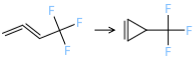

In [47]:
model_1_reactions[1308] #S(4579) <=> S(7874)


In [48]:
model_1_reactions[1309] #H(8) + C3H3(6822) <=> CH2(S)(25) + C2H2(23)

In [50]:
model_1_reactions[1310] #H(8) + C3H3(6822) <=> CH3(19) + C2H(22)

In [51]:
model_1_reactions[1311] #H(8) + C3H3(6822) <=> CH2(S)(25) + H2CC(24)

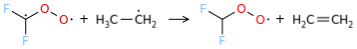

In [52]:
model_1_reactions[1312] #CF2O2(848) + C2H5(32) <=> S(2391) + C2H4(30)

from : https://www.nature.com/articles/s41598-022-08648-5.pdf?origin=ppub

"The production of OH radicals is immensely dependent upon the availability of H radicals. Hence, the
reactions consuming H radicals like the H-abstraction of the fuel, CH4+H ⇔ CH3+ H2, compete with the OH
forming reactions and therefore has a large negative sensitivity. Also, this reaction is a chain propagation reaction as opposed to the chain branching reaction: **O2+H ⇔ O+OH, which produces two reactive radicals that can
help initiate and sustain the flame.** Similarly, the H producing reactions for, e.g., 2CH3 ⇔ H+ C2H5 have a positive sensitivity. Correspondingly, the OH producing reactions such as CH3+ O2 ⇔ CH2O+OH, CH2O+ O2 ⇔
HCO+OH, and CH3+ HO2 ⇔ CH3O+OH have a positive impact upon OH availability. All these reactions are
again chain branching reactions. Te reaction 2CH3 (+M) ⇔ C2H6 (+M), competes with the reaction between
CH3 with O2 and HO2 to produce OH radicals and thus has a negative sensitivity"

Next question: how significant is this reaction? is it consuming a significant amount of H radicals for this reasoning to be true?